# Data Storytelling

In this data storytelling project, I will proceed further from where I left off at data wrangling project. Because reveiw (text) is my main feature, I need more feature engnineering and then I will explore data with all features prepared. My main questions are 1) how sentiment scores are distributed 2) what words reviews of same helpfulness rating share, 3) whether text based features show distinction by helpfulness rating, 4) which features show strong correlation to the target (helpfulness rating) 5) which features show collinearlity each other 6) if there are any patterns among features 7) how helpfulness ratings are distributed by categories and 8) if features show any patterns over time period. I will add more as I proceed with data if I find somthing interesting and will answer these questinos.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import gc # memory control
from textblob import TextBlob
from textblob import Word # for lemmatization
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
## modules for generating the word cloud
from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

sns.set(style="whitegrid")
plt.style.use('seaborn')

In [2]:
# read dataframe from wrangling procedure
df = pd.read_csv('df_clean_final.csv.gz', compression='gzip', parse_dates=['reviewTime'], low_memory=False)

# 1. Data preparation
I am using Amazone review dataset cleaned in previous wrangling stage which consists of 1,242,546 rows and 9 columns. In this step, I split the dataset into training and validation sets so that we can train and test classifier. Recall that our target is 'helpfulness'

In [3]:
## split the dataset into training and validation datasets 
## train:test = 4:1
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['helpfulness']), df['helpfulness'], 
                                                    test_size=0.2, random_state=77)

In [4]:
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1242546, 9), (994036, 8), (994036,), (248510, 8), (248510,))

In [5]:
X_train.head(3)

reviewerID        asin  overall reviewTime   categories  \
74752    A3DMPV6RWRHPM3  0306813920      3.0 2005-11-30        Books   
848950    AZYJ9TS07B02W  B000O178BY      3.0 2007-04-19  CDs & Vinyl   
1086666  A18U7ZLAA90PNM  B004TLH6HQ      1.0 2011-06-07  Electronics   

            price  helpful_num  \
74752    0.353767           26   
848950   0.534737            8   
1086666  0.371038           26   

                                                    review  
74752    Informative, but unbalanced.. This bio gave me...  
848950   Boogie Apocalypse. Yeow, what a disappointment...  
1086666  False advertising - Does NOT fit IPad 2. I hav...

In [6]:
y_train.head()

74752      5.0
848950     2.0
1086666    5.0
1092826    4.0
345807     3.0
Name: helpfulness, dtype: float64

In [7]:
## Check if there happened to create null values importing data
df.isnull().sum()

reviewerID     0
asin           0
overall        0
reviewTime     0
categories     0
price          0
helpful_num    0
helpfulness    0
review         0
dtype: int64

#  2. Feature Engineering for Text 
In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset. Also, I will try to summarize those features' characteristics with visualization.

> Following features will be added along the way:
    1. Sentiment Score as features
        * Polarity
        * Subjectivity
    2. Text / NLP based features
        * Word Count of the documents
        * Character Count of the documents
        * Average Word Density of the documnets
        * Punctuation Count in the Complete Review
        * Upper Case Count in the Complete Review
        * Title Word Count in the Complete Review
        * Frequency distribution of Part of Speech Tags:
            * Noun Count
            * Verb Count
            * Adjective Count
            * Adverb Count
            * Pronoun Count
    3. TF-IDF Vectors as features
        - Word level (O)
        - N-Gram level (X)
        - Character level (X)

## 2.1. Sentiment Analysis
Polarity is a float value within the range \[-1.0 to 1.0] where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.

Subjectivity is a float value within the range \[0.0 to 1.0] where 0.0 is very objective and 1.0 is very subjective. Subjective sentence expresses some personal feelings, views, beliefs, opinions, allegations, desires, beliefs, suspicions, and speculations where as Objective sentences are factual.

In [8]:
## train data
temp = X_train['review'].map(lambda x: TextBlob(x).sentiment).apply(pd.Series) 
## add sentiment polarity feature: [-1.0, 1.0]
X_train['polarity'] = temp[0]
## add sentiment subjectivity features: [0.0, 1.0]
X_train['subjectivity'] = temp[1]


## test data
temp = X_test['review'].map(lambda x: TextBlob(x).sentiment).apply(pd.Series) 
## add sentiment polarity feature: [-1.0, 1.0]
X_test['polarity'] = temp[0]
## add sentiment subjectivity features: [0.0, 1.0]
X_test['subjectivity'] = temp[1]


## delete temp dataframe and release RAM/memory
del [temp]
gc.collect();

### Visualize distibution of polarity and subjectivity

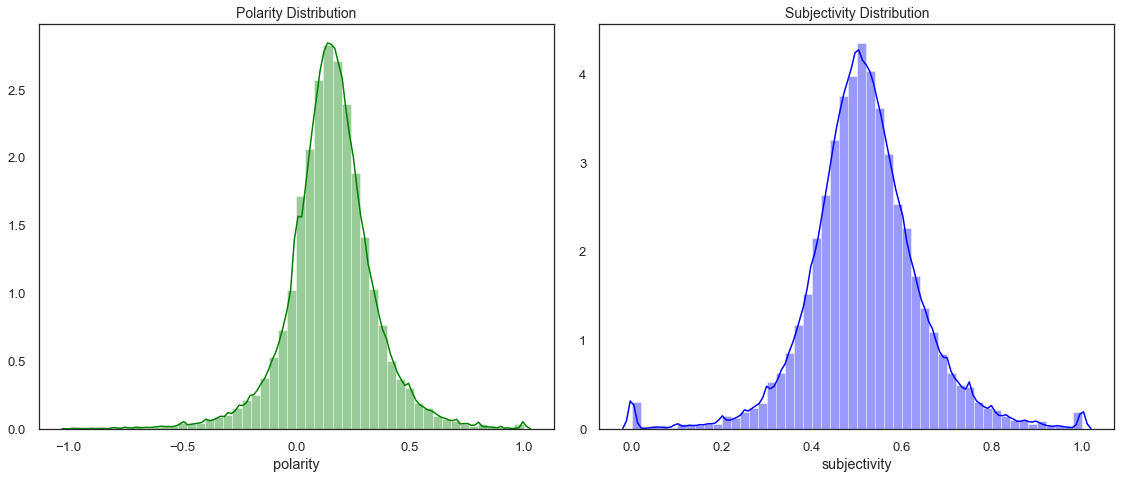

polarity   subjectivity
count  994036.000000  994036.000000
mean        0.153905       0.516458
std         0.188924       0.123719
min        -1.000000       0.000000
25%         0.056439       0.449464
50%         0.153819       0.513095
75%         0.253805       0.582500
max         1.000000       1.000000

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.set(style="white", font_scale=1.5)

sns.distplot(X_train['polarity'], color='green', bins=50, hist_kws={'alpha': 0.4}, ax=ax1)
ax1.set_title('Polarity Distribution', fontsize=14)

sns.distplot(X_train['subjectivity'], color='blue', bins=50, hist_kws={'alpha': 0.4}, ax=ax2)
ax2.set_title('Subjectivity Distribution', fontsize=14)

plt.tight_layout()
plt.show()

X_train[['polarity', 'subjectivity']].describe()

We observe that both distribution seem symmetric from the mean. One peculiar thing is polarity is a little bit biased toward positive sentiment score (mean is 0.15, not 0.0) and subjectivity distribution shows there are some extremely subjective reviews (note 0.0 and 1.0 from the chart)

### Visualize data based on helpfulness rating
First I will show word clouds and then distribution of polarity and subjectivity by helpfulness rating

In [12]:
## For easiness of experiment, let's combine X_train, y_train together into a data frame
df = pd.concat([X_train, y_train], axis=1)

## divide dataframe based on helpfulness rating
df0 = df[df['helpfulness'] == 0.0]
df1 = df[df['helpfulness'] == 1.0]
df2 = df[df['helpfulness'] == 2.0]
df3 = df[df['helpfulness'] == 3.0]
df4 = df[df['helpfulness'] == 4.0]
df5 = df[df['helpfulness'] == 5.0]

## join all texts together
text0 = df0.review.str.cat(sep=" ")
text1 = df1.review.str.cat(sep=" ")
text2 = df2.review.str.cat(sep=" ")
text3 = df3.review.str.cat(sep=" ")
text4 = df4.review.str.cat(sep=" ")
text5 = df5.review.str.cat(sep=" ")

In [13]:
## prepare stopwords to remove common 1000 frequent words
text = df.review.str.cat(sep=" ")
stopwords_list = Counter(text.lower().split()).most_common(1000)
stopwords_list = [item[0] for item in stopwords_list]
stopwords_set = stopwords.words('english') + stopwords_list + ['quot']

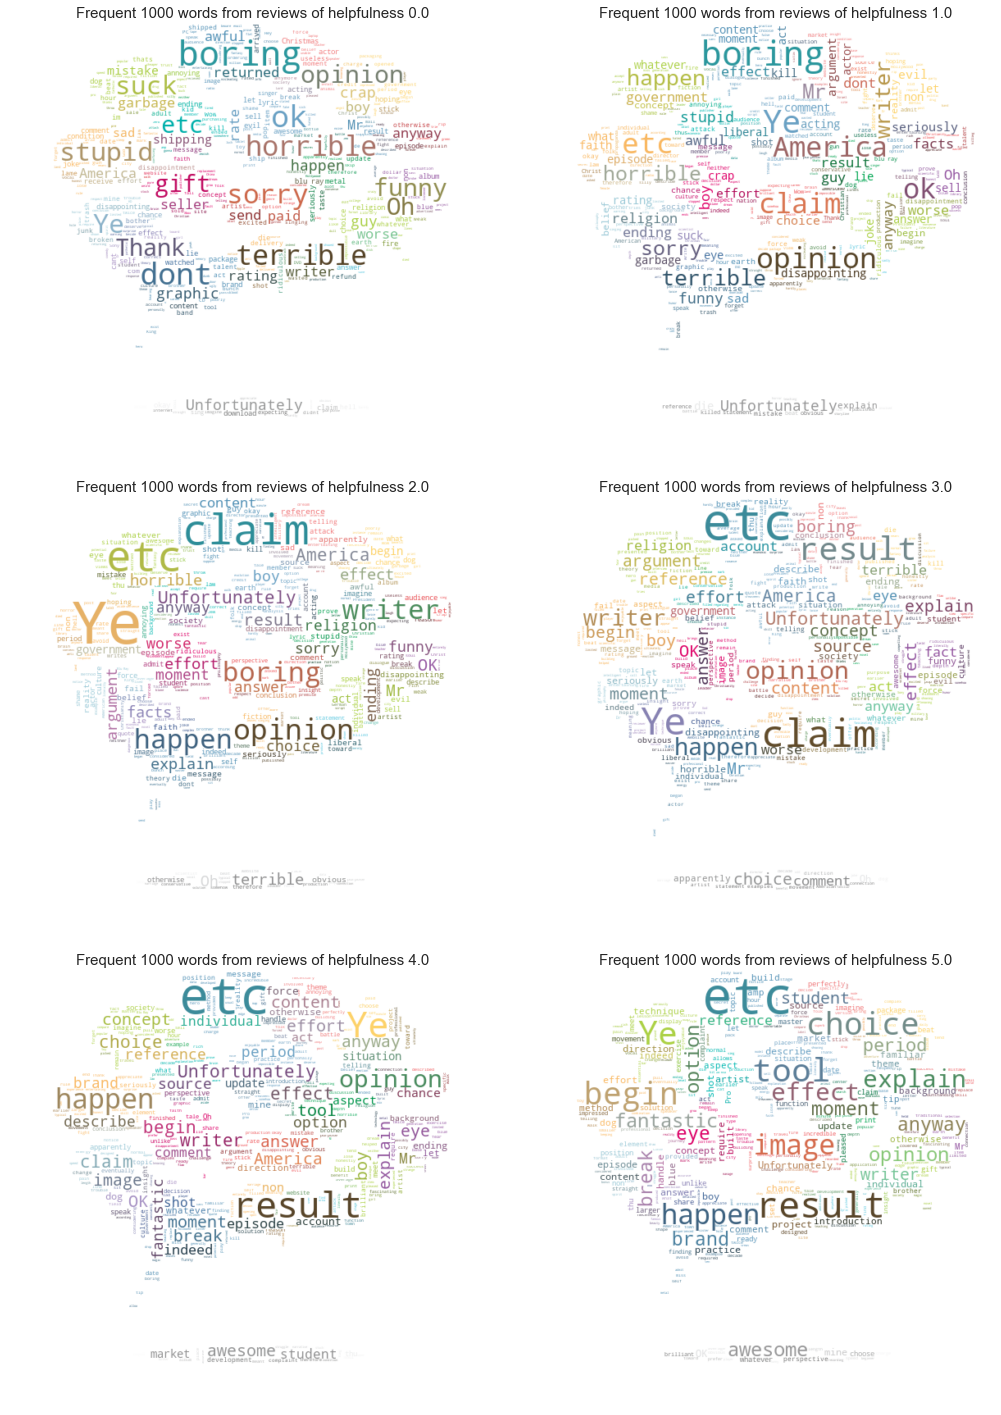

In [15]:
## get path of image
d = getcwd()
icon_path = path.join(d, "images/review_image.png")

## pre-set image
icon = Image.open(icon_path).convert("RGBA")
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon, icon)
mask = np.array(mask)

fig = plt.figure(figsize=(15, 20))

for i in range(6):
    ## Word Cloud with colored mask
    wc = WordCloud(background_color="white", max_words=1000, stopwords=stopwords_set,
                   mask=mask, max_font_size=90, random_state=42)
    wc.generate(globals()['text'+str(i)])

    ## create coloring from image
    coloring = np.array(Image.open(icon_path))
    image_colors = ImageColorGenerator(coloring)
    image_colors.default_color = [0.6, 0.6, 0.6]

    ## Generate word Cloud
    ax = fig.add_subplot(3, 2, i+1)
    ax.set_title('Frequent 1000 words from reviews of helpfulness {}'.format(float(i)), fontsize=15)
    ax.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    ax.axis("off")
    
plt.tight_layout()
plt.show();

Even though I removed 1000 most common words in entire reviews, there are some words that are common in all word clouds. However, they are not present in all word clouds; some word groups are observed in lower helpfulness rating group and some are in higher, and we see the size of certain word changes as helpfulness rating changes. For example, when you see helpfulness 0 and 1 word clouds, you see a word 'boring' and its size is getting smaller in helpufulness 2 and 3 word clouds and hard to be found in helpfulness 4 and 5 word clouds.

### Polarity and Subjectivity Distribution by helpfulness rating

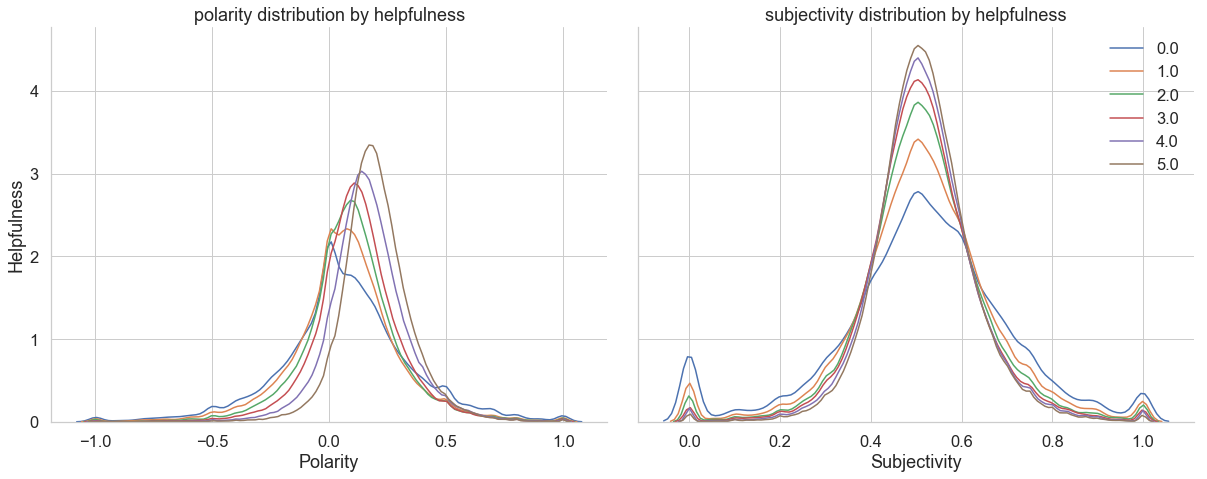

In [16]:
melted = df.melt(id_vars=['helpfulness'], value_vars=['polarity', 'subjectivity'])

sns.set(style="whitegrid", font_scale=1.5)
g = sns.FacetGrid(melted, hue='helpfulness', col= 'variable', height=7, aspect=1.2, sharex=False)
g.map(sns.kdeplot, 'value')
g.set_titles('{col_name} distribution by helpfulness')
sns.despine(right = True, top = True)
g.axes[0,0].set_xlabel('Polarity')
g.axes[0,1].set_xlabel('Subjectivity')
g.axes[0,0].set_ylabel('Helpfulness')
plt.legend();

As we can see from polarity distribution, the higher helpfulness rating is the more polarity is biased toward the positive and its shape is pointed. On the other hand, subjectivity shows more centeralizing tendency as helpfulness increases.

## 2.2 Text/NLP based features
A number of extra text based features can also be created which sometimes are helpful for improving text classification models.

1. Word Count of the documents – total number of words in the documents
2. Character Count of the documents – total number of characters in the documents
3. Average Word Density of the documnets – average length of the words used in the documents
4. Punctuation Count in the Complete Review – total number of punctuation marks in the documents
5. Upper Case Count in the Complete Review – total number of upper count words in the documents
6. Title Word Count in the Complete Review – total number of proper case (title) words in the documents
7. Frequency distribution of Part of Speech Tags:
    * Noun Count
    * Verb Count
    * Adjective Count
    * Adverb Count
    * Pronoun Count

In [17]:
## 1. Word count 
X_train['word_count'] = X_train['review'].apply(lambda x: len(x.split()))
X_test['word_count'] = X_test['review'].apply(lambda x: len(x.split()))

## 2. Character count 
X_train['char_count'] = X_train['review'].apply(len)
X_test['char_count'] = X_test['review'].apply(len)

## 3. Average word density
X_train['word_density'] = X_train['char_count'] / (X_train['word_count']+1)
X_test['word_density'] = X_test['char_count'] / (X_test['word_count']+1)

## 4. Pounctuation Count
X_train['punctuation_count'] = X_train['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
X_test['punctuation_count'] = X_test['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

## 5. Uppercase word count
X_train['uppercase_count'] = X_train['review'].apply(lambda x: len([word for word in x.split() if word.isupper()]))
X_test['uppercase_count'] = X_test['review'].apply(lambda x: len([word for word in x.split() if word.isupper()]))

## 6. Title word count
X_train['title_count'] = X_train['review'].apply(lambda x: len([word for word in x.split() if word.istitle()]))
X_test['title_count'] = X_test['review'].apply(lambda x: len([word for word in x.split() if word.istitle()]))

In [18]:
## 7. Frequency distribution of POS

## group pos
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}


## function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x):
    noun = 0
    verb = 0
    adj = 0
    adv = 0
    pron = 0
    
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family['noun']:
                noun += 1
            elif ppo in pos_family['verb']:
                verb += 1
            elif ppo in pos_family['adj']:
                adj += 1
            elif ppo in pos_family['adv']:
                adv += 1
            elif ppo in pos_family['pron']:
                pron += 1
    except:
        pass
    return [noun, verb, adj, adv, pron]

## Partial insertion of POS into dataframe
def insert_pos(df, df_idx, indexes, start):
    count_holder = df.review.loc[df_idx[indexes[start]:indexes[start+1]]].map(check_pos_tag)
    
    df['noun_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[0])
    df['verb_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[1])
    df['adj_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[2])
    df['adv_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[3])
    df['pron_count'].loc[df_idx[indexes[start]:indexes[start+1]]] = count_holder.map(lambda x: x[4])
    
    return df

In [19]:
## define X_train indexes, helper array for chunkifying
df_idx = X_train.index.values
indexes = np.arange(0, 21)*50000

## initialize column
X_train['noun_count'] = 0
X_train['verb_count'] = 0
X_train['adj_count'] = 0
X_train['adv_count'] = 0
X_train['pron_count'] = 0

In [20]:
## chunkify X_train data frame into 20 chunks and process. Each line takes on 50,000 rows except last one
X_train = insert_pos(X_train.copy(), df_idx, indexes, 0)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 1)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 2)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 3)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 4)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 5)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 6)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 7)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 8)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 9)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 10)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 11)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 12)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 13)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 14)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 15)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 16)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 17)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 18)
X_train = insert_pos(X_train.copy(), df_idx, indexes, 19)

In [21]:
## define X_test indexes, helper array for chunkifying
df_idx = X_test.index.values
indexes = np.arange(0, 6)*50000

## initialize column
X_test['noun_count'] = 0
X_test['verb_count'] = 0
X_test['adj_count'] = 0
X_test['adv_count'] = 0
X_test['pron_count'] = 0

In [22]:
## split X_train data frame into 5 chunks and process. Each line takes on 50,000 rows except last one
X_test = insert_pos(X_test.copy(), df_idx, indexes, 0)
X_test = insert_pos(X_test.copy(), df_idx, indexes, 1)
X_test = insert_pos(X_test.copy(), df_idx, indexes, 2)
X_test = insert_pos(X_test.copy(), df_idx, indexes, 3)
X_test = insert_pos(X_test.copy(), df_idx, indexes, 4)

In [24]:
X_train.head(3)

reviewerID        asin  overall reviewTime   categories     price  \
0  A3DMPV6RWRHPM3  0306813920      3.0 2005-11-30        Books  0.353767   
1   AZYJ9TS07B02W  B000O178BY      3.0 2007-04-19  CDs & Vinyl  0.534737   
2  A18U7ZLAA90PNM  B004TLH6HQ      1.0 2011-06-07  Electronics  0.371038   

   helpful_num                                             review  polarity  \
0           26  Informative, but unbalanced.. This bio gave me...  0.256913   
1            8  Boogie Apocalypse. Yeow, what a disappointment... -0.016427   
2           26  False advertising - Does NOT fit IPad 2. I hav... -0.022692   

   subjectivity     ...      char_count  word_density  punctuation_count  \
0      0.537462     ...            2046      5.779661                 71   
1      0.454406     ...            1144      6.021053                 57   
2      0.546923     ...             798      5.148387                 31   

   uppercase_count  title_count  noun_count  verb_count  adj_count  adv_count  \
0                8           22          90          50         34         24   
1                4           30          55          27         23         16   
2                7           15          32          27          8         10   

   pron_count  
0          41  
1          19  
2          17  

[3 rows x 21 columns]

In [25]:
X_test.head(3)

reviewerID        asin  overall reviewTime      categories     price  \
0   AQRVDI6DFSZ86  B001MYIXAC      1.0 2009-04-02     Movies & TV  0.401135   
1  A1248JRIINWRTH  B000NQ95H0      5.0 2009-10-10  Home & Kitchen  0.506099   
2  A2F540P3L6P5CL  0547074239      2.0 2008-08-31           Books  0.346950   

   helpful_num                                             review  polarity  \
0           27  Great Film, Great Transfer, BOGUS SUBTITLES!. ...  0.173042   
1           10  Terrific quality for a great price. I was a li...  0.156119   
2            9  In need of some serious overhaul prior to publ... -0.007879   

   subjectivity     ...      char_count  word_density  punctuation_count  \
0      0.448692     ...            1607      6.351779                 63   
1      0.529524     ...            1095      5.673575                 25   
2      0.348561     ...            1084      5.474747                 29   

   uppercase_count  title_count  noun_count  verb_count  adj_count  adv_count  \
0               31           34          90          44         22          6   
1                3           11          49          36         22         12   
2               10           19          42          39         14         22   

   pron_count  
0          15  
1          12  
2          16  

[3 rows x 21 columns]

In [26]:
X_train.shape, X_test.shape

((994036, 21), (248510, 21))

## 2.3 TF-IDF Vectors as features 

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

>TF(t) = (Number of times term t appears in a document) / (Total number of terms in the  document) <br>
 IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

1. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
2. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams
3. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus

Given the size of data is large, __I will achieve 1.unigram setting ngram_range(1,1)__

In [27]:
# STEMMER = SnowballStemmer("english")
PUNCTUATION = str.maketrans('', '', string.punctuation)
DIGITS = str.maketrans('', '', string.digits)

def preprocess_text(text):    
    ## convert to lowercase, remove punctuation & remove numbers
    text = text.lower().translate(PUNCTUATION).translate(DIGITS)
    ## lemmatize words & remove extra spaces
    text = " ".join([Word(word).lemmatize("v") for word in TextBlob(text).words])
    
    return text

In [32]:
## filter out stop words of English, and too frequently used words are out, 
## less than 10 times (< 0.00081%) used words are out
## Only take top 10,000 frequent terms
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), 
                             min_df=10, max_df=0.70, max_features=10000, stop_words='english')
V_train = vectorizer.fit_transform(X_train_review_clean.values.astype('U'))
V_test = vectorizer.transform(X_test_review_clean)

In [33]:
## length of vocabulary and stopwords
len(vectorizer.vocabulary_), len(vectorizer.stop_words_)

(10000, 2143685)

### Visualize top 10,000 TFIDF score words

In [34]:
## prepare word - tfidf score dictionary
scores = zip(vectorizer.get_feature_names(),
             np.asarray(V_train.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
scores_dict = {score[0]: score[1] for score in sorted_scores}

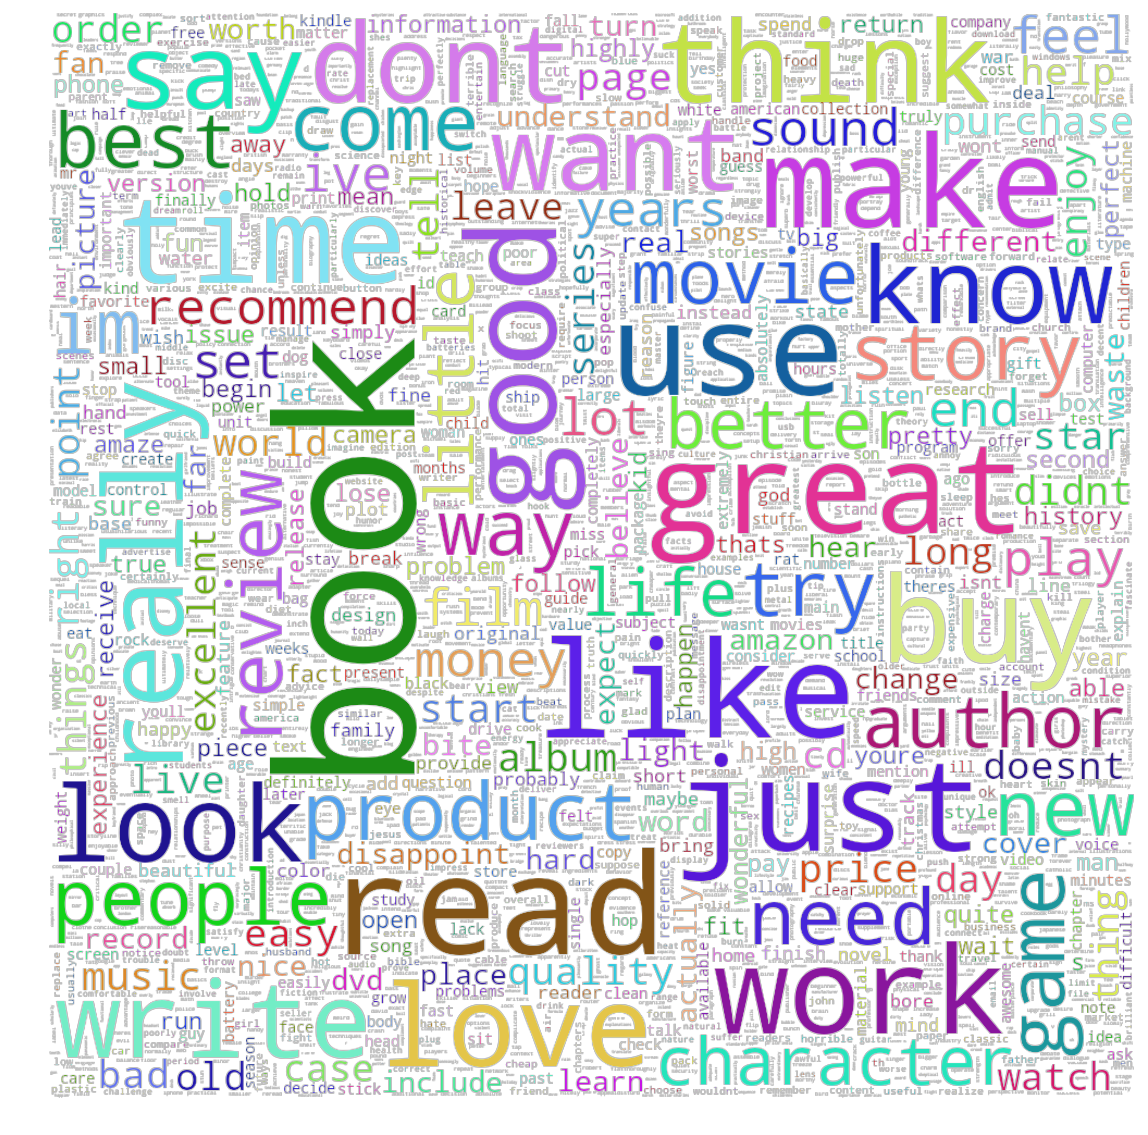

In [35]:
## color function for word cloud
def custom_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(%d,%d%%, %d%%)" % (np.random.randint(0,361), np.random.randint(70,85), np.random.randint(30,75)))

## vizualization
wc = WordCloud(width=1000, height=1000, max_words=10000, background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_font_size=175).fit_words(scores_dict)
plt.figure(figsize=(20,20))
plt.imshow(wc.recolor(random_state=3, color_func=custom_color_func), interpolation="bilinear", cmap='bwr')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

By definition tf-idf, short for term frequency-inverse document frequency, is a numerical statistic that is intended to reflect __how important a word is__ to a document in a collection of corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. Tf–idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf–idf. 

# 3. Data Exploration
I will do some experiment with data so I can get inspiration and may find patterns

In [36]:
# information of X_train + y_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994036 entries, 0 to 994035
Data columns (total 22 columns):
reviewerID           994036 non-null object
asin                 994036 non-null object
overall              994036 non-null float64
reviewTime           994036 non-null datetime64[ns]
categories           994036 non-null object
price                994036 non-null float64
helpful_num          994036 non-null int64
review               994036 non-null object
polarity             994036 non-null float64
subjectivity         994036 non-null float64
word_count           994036 non-null int64
char_count           994036 non-null int64
word_density         994036 non-null float64
punctuation_count    994036 non-null int64
uppercase_count      994036 non-null int64
title_count          994036 non-null int64
noun_count           994036 non-null int64
verb_count           994036 non-null int64
adj_count            994036 non-null int64
adv_count            994036 non-null int64
pron_c

## 3.1 Numerical Features
Let us first study collinearity among features and correlation between numerical features and our target - helpfulness
### 3.1.1 collinearity

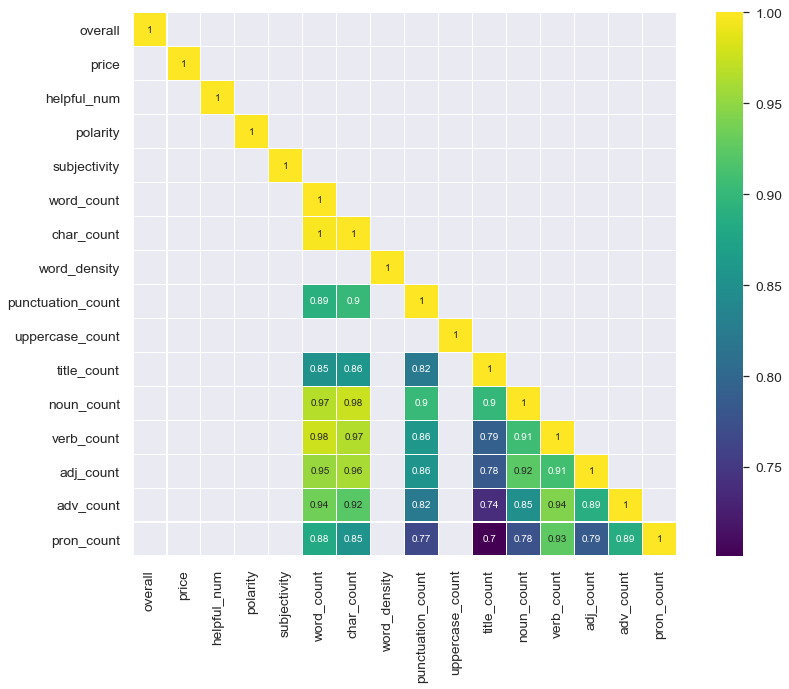

In [37]:
sns.set(font_scale=1.25)
corr = df_train.select_dtypes([int, float]).drop(columns=['helpfulness']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
plt.figure(figsize=(14,10))
with sns.axes_style("darkgrid"):
    sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], cmap='viridis', mask=mask,
                annot=True, annot_kws={'size':10}, square=True, linewidths=0.2);

We can see that noun_count, verb_count, adj_count, adv_count pron_count, word_count, char_count, punctuation count, and title_count are stronly correlated to each other. Basically, almost all count features except uppercase_count are strongly correlated and it seems somewhat natural because the longer review is, the more likely any count would increase due to English structure. For this reason, __we'll remove those highly correlated features regarding them as duplicated features; and will keep 'word_count' as a representative feature because it shows strongest collinearity with other features and has strong correlation with the target (reference 3.1.2)__

### 3.1.2 Correlation with Helpfulness

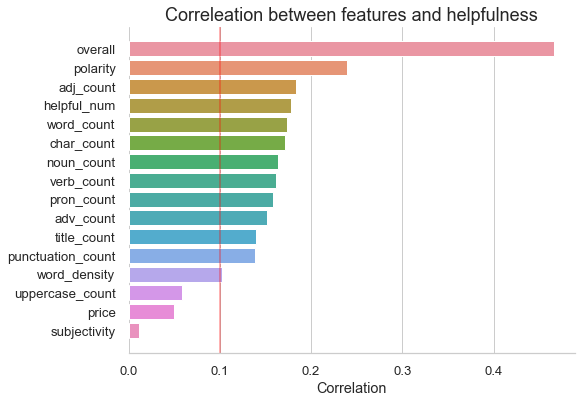

In [38]:
corr_with_target = df_train.select_dtypes([int, float]).corr()['helpfulness'].drop(['helpfulness']).sort_values(ascending=False)
sns.set(font_scale=1.2)

sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
ax = sns.barplot(x=corr_with_target, y=corr_with_target.index)
sns.despine(top=True, right=True, left=True)
ax.set_title('Correleation between features and helpfulness', fontsize=18)
# By using ``transform=ax.get_xaxis_transform()`` the y coordinates are scaled
# such that 0 maps to the bottom of the axes and 1 to the top.
ax.vlines(0.1, 0,1, transform=ax.get_xaxis_transform(), colors='red', alpha=0.4)
ax.set_xlabel('Correlation');

Vertical line in red is on 0.1 which will be a criteron on determining if a feature has a strong correlation with helpfulness rating. Subjectivity shows least correlation which might denote either TextBlob does not catch subjectivity or people do not vote subjective reviews as helpful. helpful_num has high correlation as expected. Overall rating shows strongest correlation with helpfulness. Surprisingly, price has little correlation opposed to what I expected. __This results implies that 'uppercase_count', 'price' and 'subjectivity' will not be of helpful for prediction; therefore, I will drop them.__

In [39]:
drop_col = ['uppercase_count', 'price', 'subjectivity', 'char_count', 'punctuation_count', 'title_count', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']

X_train = X_train.drop(columns=drop_col)
X_test = X_test.drop(columns=drop_col)

In [40]:
X_train.head(3)

reviewerID        asin  overall reviewTime   categories  helpful_num  \
0  A3DMPV6RWRHPM3  0306813920      3.0 2005-11-30        Books           26   
1   AZYJ9TS07B02W  B000O178BY      3.0 2007-04-19  CDs & Vinyl            8   
2  A18U7ZLAA90PNM  B004TLH6HQ      1.0 2011-06-07  Electronics           26   

                                              review  polarity  word_count  \
0  Informative, but unbalanced.. This bio gave me...  0.256913         353   
1  Boogie Apocalypse. Yeow, what a disappointment... -0.016427         189   
2  False advertising - Does NOT fit IPad 2. I hav... -0.022692         154   

   word_density  
0      5.779661  
1      6.021053  
2      5.148387

### 3.1.3 Other Numerical Features
Let us explore numerical features with pair plot.

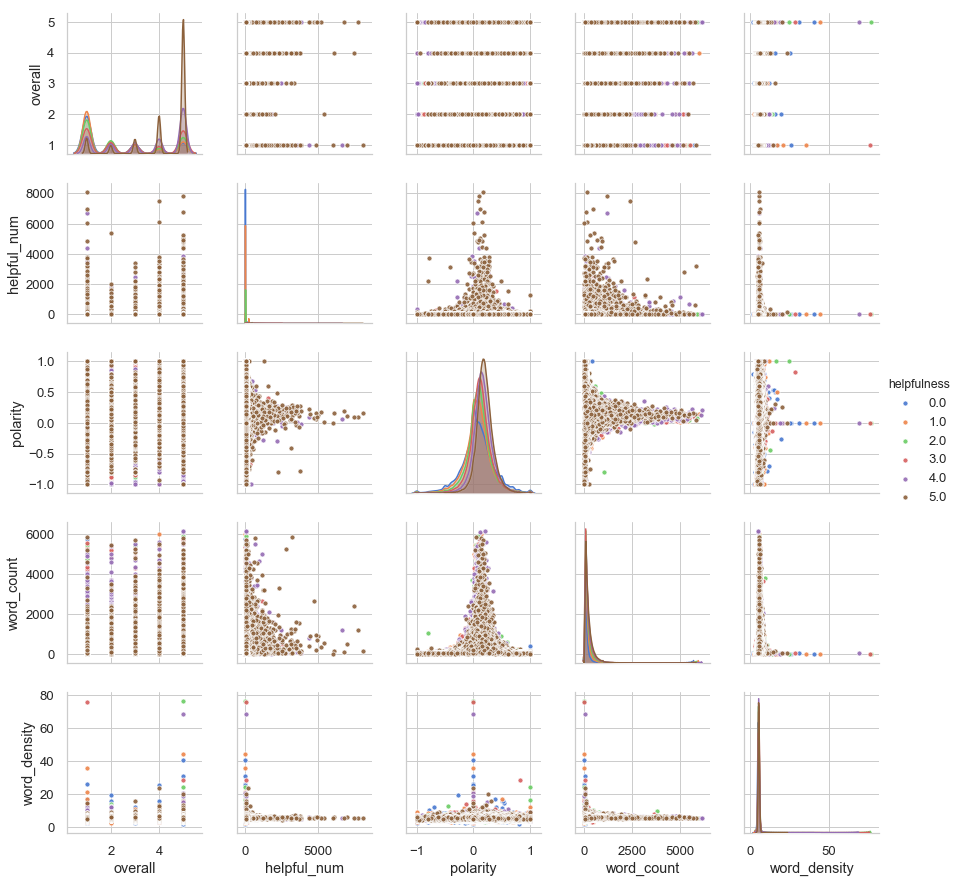

In [41]:
df_train = pd.concat([X_train, y_train], axis=1)

numericals = df_train.select_dtypes([int, float]).copy()
sns.set_style("whitegrid")
sns.pairplot(df_train.select_dtypes([int, float]), hue='helpfulness', palette='muted',
             vars=numericals.columns.drop(['helpfulness']).values, plot_kws={'alpha': 0.9, 's':25});

There are some points worth dicsussing:
1. From polarity-helpful_num scatter plot, users tend not to vote for polar reviews; they want neutral reviews or slightly positive reviews.
2. helpful_num and word_count are seemingly in inverse proportion to each other, that shows people do not usually favors very length reivew. 
3. world_count-polarity plot is parallel to helpful_num-polarity. It seems neutral or slightly positive reviews have more lenghty (i.e. have more words). 
4. Given word_density related plots, people do not like "big" words. By definition, word dencity is average length of the words used. 
5. From overall distribution, we can see it is biased toward rating 1 or 5 which shows people rate the product rather in extreme fashion. Interestingly, helpfull rating 5 reviews tend to have high overall rating (4 or 5)
6. helpful number is highly right-skewed 

## 3.2 Categorical Features

In [43]:
categoricals = df_train.select_dtypes([object])
categoricals = pd.concat([categoricals, df_train.helpfulness], axis=1)
categoricals.head()

reviewerID        asin         categories  \
0  A3DMPV6RWRHPM3  0306813920              Books   
1   AZYJ9TS07B02W  B000O178BY        CDs & Vinyl   
2  A18U7ZLAA90PNM  B004TLH6HQ        Electronics   
3   AFGC66F26WG0V  B004YTKR2E  Sports & Outdoors   
4  A2YW63J587H6KJ  0886777100              Books   

                                              review  helpfulness  
0  Informative, but unbalanced.. This bio gave me...          5.0  
1  Boogie Apocalypse. Yeow, what a disappointment...          2.0  
2  False advertising - Does NOT fit IPad 2. I hav...          5.0  
3  Perfect for plus size dancer. Pole got to my h...          4.0  
4  And then I decided to watch some paint dry. I ...          3.0

### 3.2.1 Distribution of number of reviews per user 

In [44]:
print("User number is: {}".format(categoricals.reviewerID.unique().shape[0]))
print("Review ratio to user number is: {}".format(categoricals.shape[0]/categoricals.reviewerID.unique().shape[0]))

User number is: 707539
Review ratio to user number is: 1.404920435481295


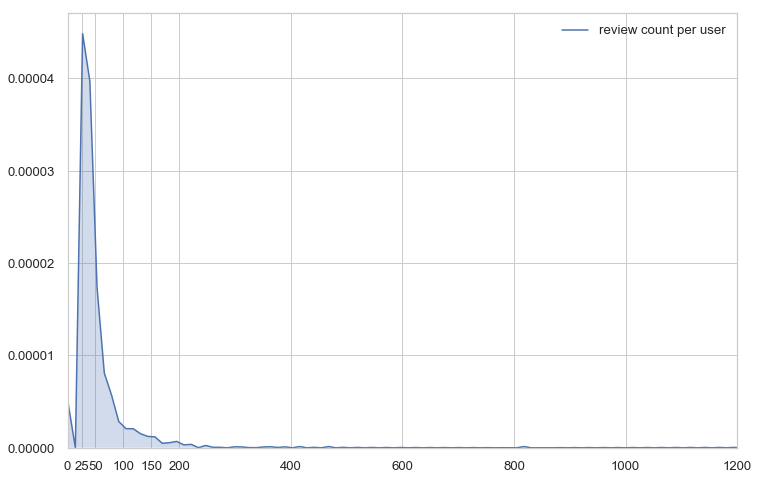

In [45]:
cat_df = categoricals.groupby(['reviewerID'])['helpfulness'].count().rename("review count per user")
plt.figure(figsize=(12,8))
ax = sns.kdeplot(cat_df, shade=True);
ax.set_xlim((0, 1200))
ax.set_xticks([0, 25, 50, 100, 150, 200, 400, 600, 800, 1000, 1200]);

It seems not many people write more than 1 review from mean review number per user. We can see that review number is highly right skewed and after 25 review count, graph plummets. Also we can observe that there rarely are "super" users who write reviews more than 200 times. Therefore, given distritubion, we can conclude that most people write review less then 200 times and most commonly they write 25 reiviews.

### 3.2.2 Helpfulness distribution by categories & Number of reviews per categories

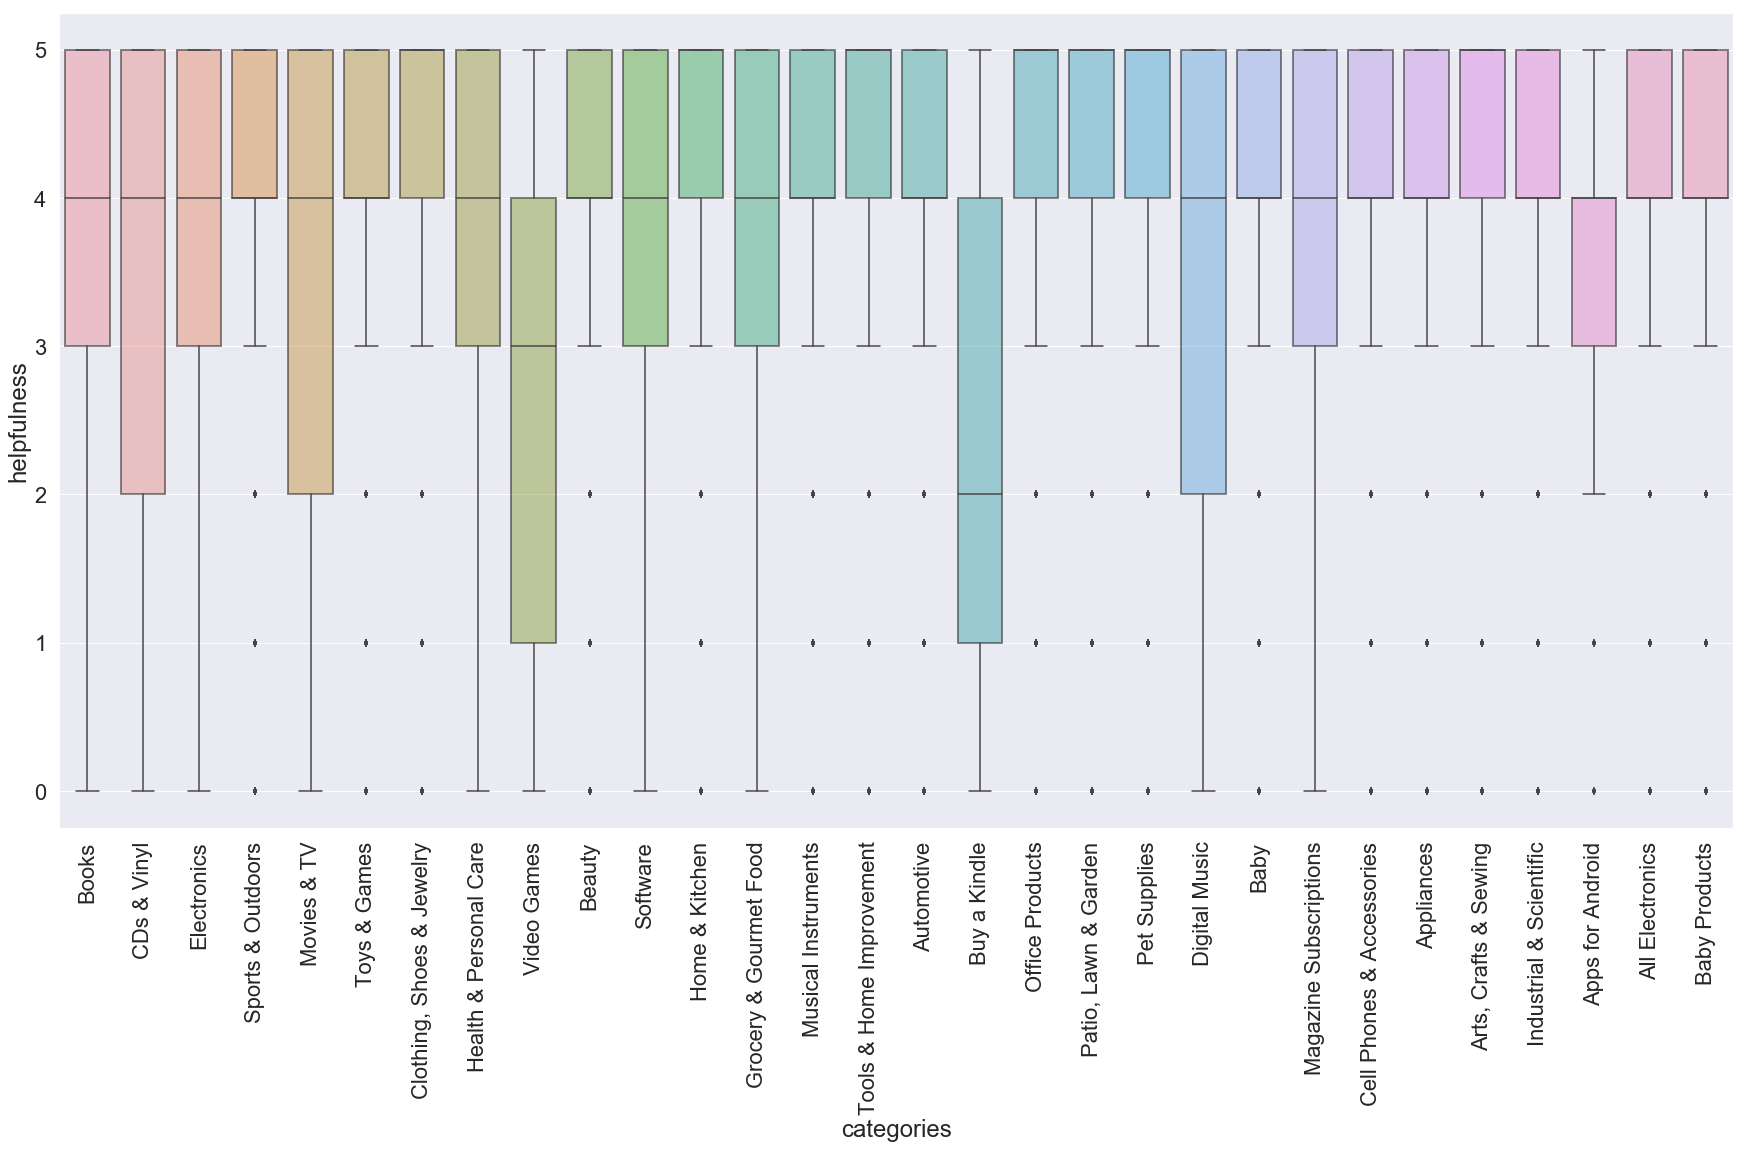

In [46]:
plt.figure(figsize=(30, 15))
sns.set(font_scale=2)
ax = sns.boxplot(x='categories', y='helpfulness', data=categoricals)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=90);

Almost all categories lay disproportionately to high helpfulness scores having median near 4 or at 5. Only 'Video Games' or 'Buy a Kindle' useres are stingier about helpfulness rating than those of other categories in general. However this is not very surprising given our dataset was strongly right-skewed overall.

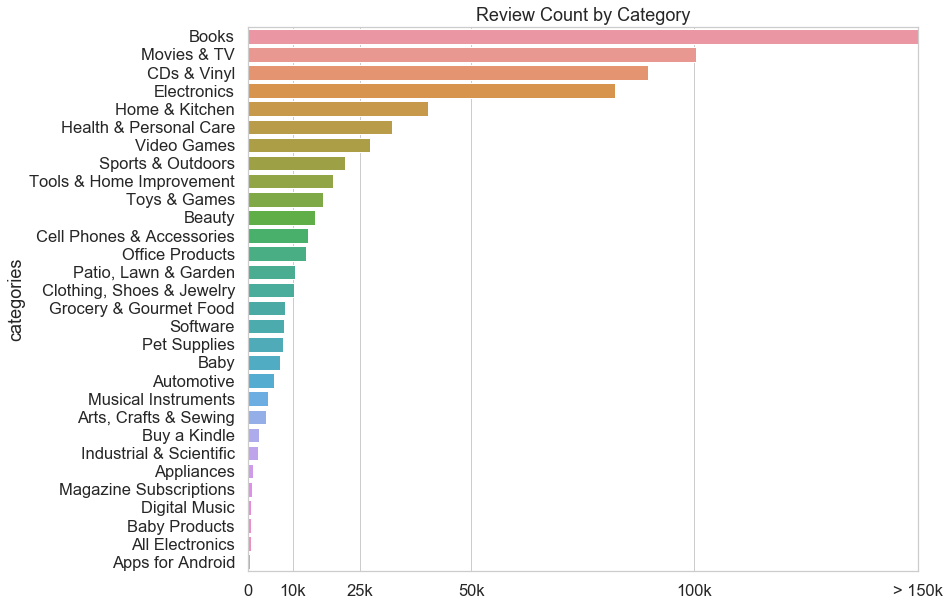

In [47]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
plt.figure(figsize=(12,10))
ax = sns.countplot(y='categories', data=categoricals,
                  order=categoricals.groupby(['categories'])['helpfulness'].count().sort_values(ascending=False).index.values);
ax.set_xlim((0, 150000))
ax.set_xticks([0, 10000 , 25000, 50000, 100000, 150000])
ax.set_xticklabels([0, "10k", "25k", "50k", "100k", "> 150k"]);
ax.set_title('Review Count by Category')
ax.set_xlabel('');

Books, Movies & TV, CDs & Vinyle, and Electronics compose majority portion of reviews and Home & Kitchen and others follow. This plot mean users in high ranked categories are more actively participating in voting. You are more likely able to find helpful reviews at those category sections than at other sections.

### 3.2.3 Changes over time
I will explore how helpfulness rating changes over period of time

year
1996         1
1997       519
1998      3124
1999     10838
2000     38761
2001     33074
2002     33914
2003     37234
2004     53826
2005     74020
2006     72751
2007     70957
2008     64608
2009     72058
2010     86358
2011    105089
2012    110547
2013    100630
2014     25727
Name: year_count, dtype: int64


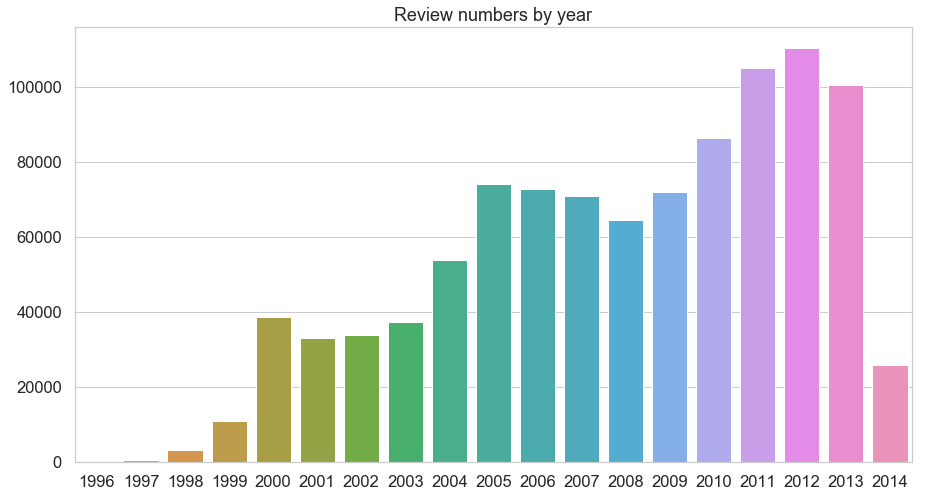

In [48]:
year_count = df_train.groupby(df_train.reviewTime.dt.year)['helpfulness'].count().rename('year_count').rename_axis("year")

print(year_count)
plt.figure(figsize=(15,8))
sns.barplot(x=year_count.index.values, y=year_count.values);
plt.title("Review numbers by year");

Year 1996 has only 1 review, so I will exclude it from visualization below. Also, keep in mind that data spans May 1996 to July 2014, and this might explan sudden drop in 2014.

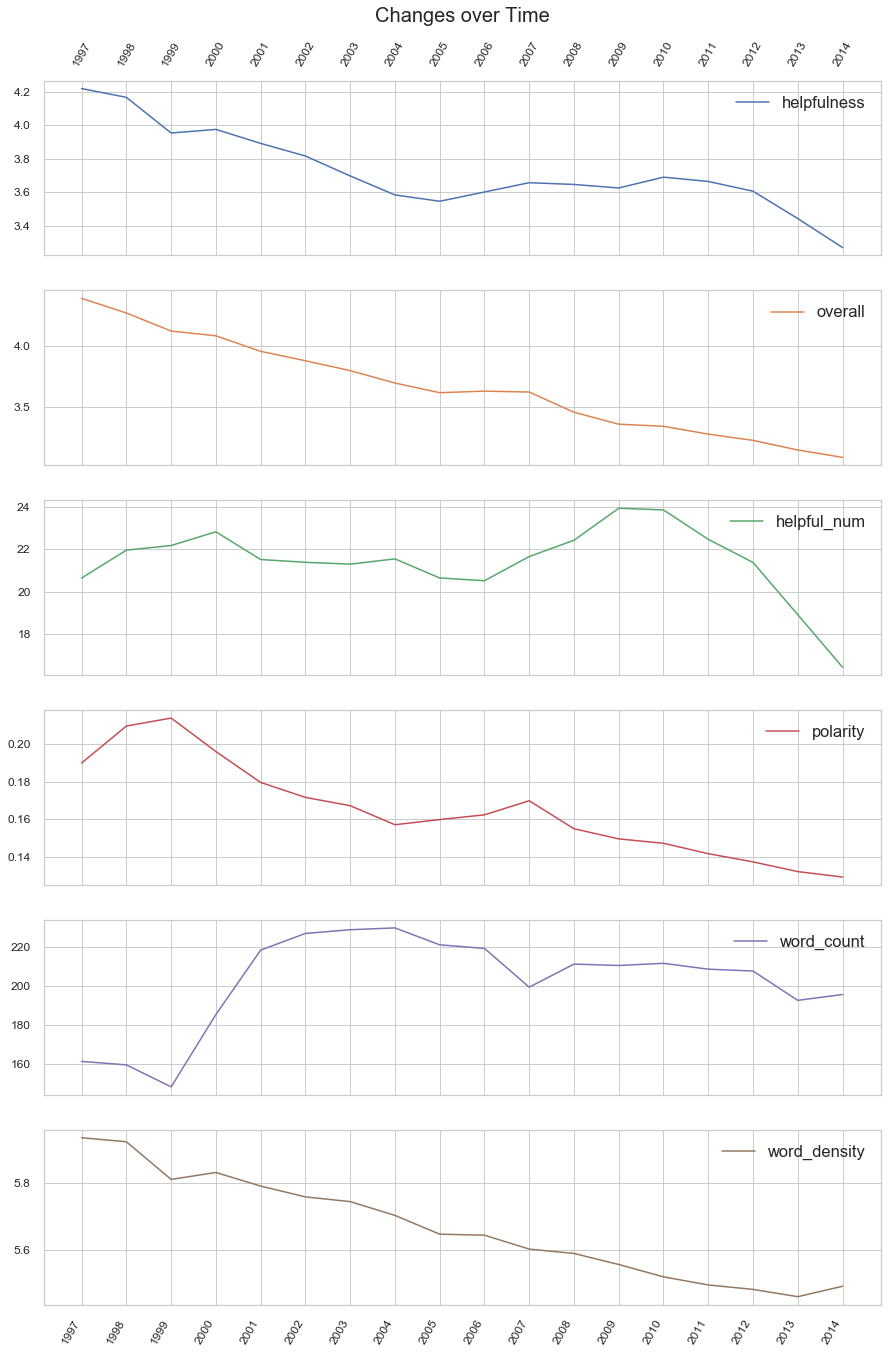

In [55]:
# groupby review 'year' and reorder columns
dff = df_train.groupby(df_train.reviewTime.dt.year).mean()[['helpfulness', 'overall', 'helpful_num', 'polarity', 'word_count', 'word_density']]
dff = dff.drop([1996])
years = dff.index.values

sns.set_style("whitegrid");
axs = dff.plot(subplots=True, figsize=(15, 25), sharex=True, xticks=years, rot=60, fontsize=12);
axs[0].tick_params(labelbottom=False,labeltop=True, labelsize=12);
axs[0].set_xticklabels(years, rotation=60);
axs[0].set_title("Changes over Time", y=1.3, fontsize=20)
plt.xlabel('');

1. Helpfulness rating, in general, is decreasing over time
2. Overall rating shows decreasing trend as well but more sharply
3. helpful_num was stable from 1997 for more than 10 years, but from 2011 it shows a deacreasing trend. This might mean increasing rate of total product number at Amazon is is faster than that of user number.
4. Reviews were always laid on positive in average and after it reached its peak at 1999, it reviews are being headed to neautral.
5. Word count seems quite stable compared to other features. 
6. People are less using long words. This might imply everyday-english reviews more appeal to people and get more votes.

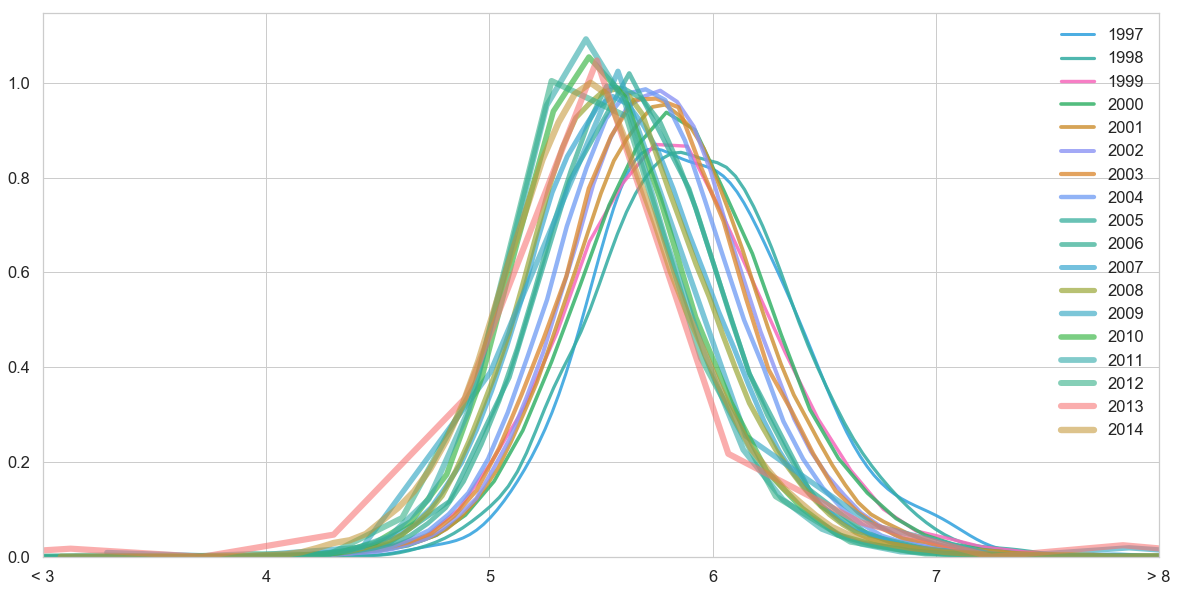

In [57]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")


fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.set_xlim((3, 8))
ax.set_xticks([3, 4, 5, 6, 7, 8])
ax.set_xticklabels(["< 3", 4, 5, 6, 7, "> 8"]);
colors = sorted(np.arange(40), key=lambda k: np.random.random())
years = np.delete(sorted(df_train.reviewTime.dt.year.unique()), 0)
i=0
for year in years:
    dff = df_train[df_train.reviewTime.dt.year == year]
    sns.kdeplot(dff['word_density'], ax=ax, color=sns.color_palette("husl", 40)[colors[i]], label=year, linewidth=3+0.2*i, alpha=0.9-0.02*i)
    i += 1

When seeing distribution of word density in given year, it does not show much differences.

(0, 1.2)

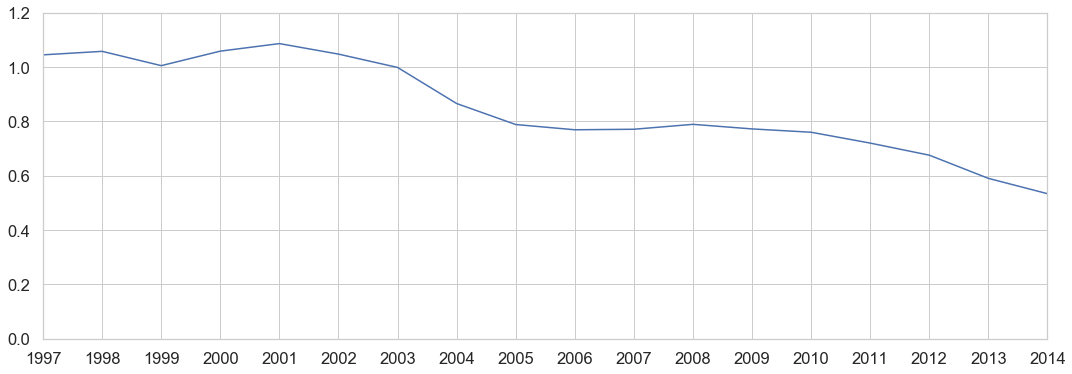

In [58]:
ratios = []
for year in years:
    dff = df_train[df_train.reviewTime.dt.year == year]
    ratio_product_to_user = len(dff.asin.unique())/len(dff.reviewerID.unique())
    ratios.append(ratio_product_to_user)
plt.figure(figsize=(18, 6))
plt.plot(years, ratios)
plt.xlim((1997, 2014))
plt.xticks(years);
plt.ylim((0, 1.2))

As opposed to what I expected earlier, user increase rate is faster than that of product, at least in the dataset where each reaview has helpfulness rating. Then, we can assume people are less apt to participate in voting helpful reviews. 